In [1]:
# 导入所需的包
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style='whitegrid')


In [5]:
# 读取数据
df = pd.read_csv('sph6004_assignment1_data.csv')

# 查看数据前几行
print(df.head(0))

# 查看数据摘要信息
print(df.info())

# 查看 aki_stage 的分布情况
print(df['aki_stage'].value_counts())


Empty DataFrame
Columns: [id, hospital_mortality, aki_stage, gender, admission_age, race, heart_rate_min, heart_rate_max, heart_rate_mean, sbp_min, sbp_max, sbp_mean, dbp_min, dbp_max, dbp_mean, mbp_min, mbp_max, mbp_mean, resp_rate_min, resp_rate_max, resp_rate_mean, temperature_vital_min, temperature_vital_max, temperature_vital_mean, spo2_min, spo2_max, spo2_mean, glucose_vital_min, glucose_vital_max, glucose_vital_mean, lactate_min, lactate_max, ph_min, ph_max, so2_min, so2_max, po2_min, po2_max, pco2_min, pco2_max, aado2_min, aado2_max, aado2_calc_min, aado2_calc_max, pao2fio2ratio_min, pao2fio2ratio_max, baseexcess_min, baseexcess_max, bicarbonate_bg_min, bicarbonate_bg_max, totalco2_min, totalco2_max, hematocrit_bg_min, hematocrit_bg_max, hemoglobin_bg_min, hemoglobin_bg_max, carboxyhemoglobin_min, carboxyhemoglobin_max, methemoglobin_min, methemoglobin_max, temperature_bg_min, temperature_bg_max, chloride_bg_min, chloride_bg_max, calcium_bg_min, calcium_bg_max, glucose_bg_min, 

c:\Users\11820\miniconda3\envs\SPH6004_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\11820\miniconda3\envs\SPH6004_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\11820\miniconda3\envs\SPH6004_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\11820\miniconda3\envs\SPH6004_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\11820\miniconda3\envs\SPH6004_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2461

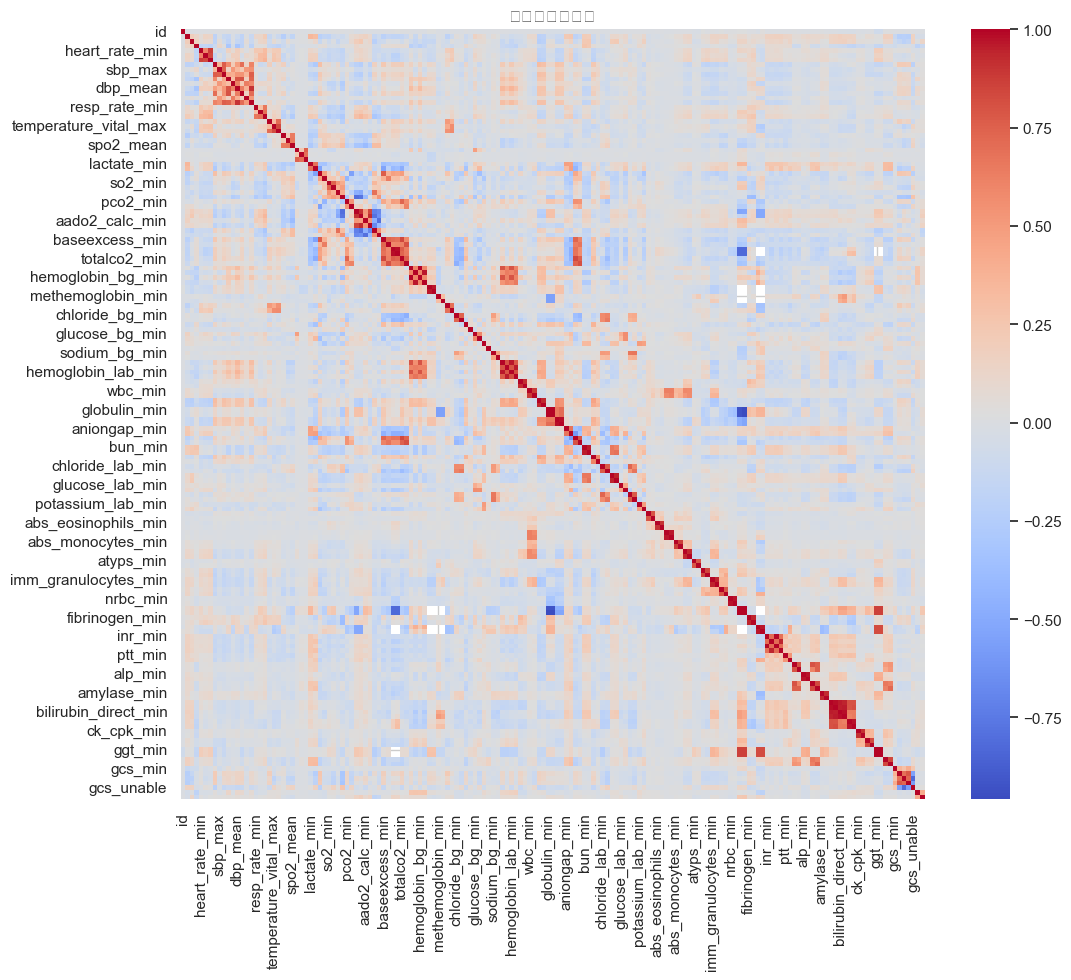

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算部分数值特征之间的相关性
corr_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('')
plt.show()


In [5]:
# 定义目标变量和特征（此处排除 id 以及其它你认为不参与预测的列）
target = 'aki_stage'
# 这里假设我们选择以下几个变量作为特征示例，你可以根据实际情况进行调整：
feature_cols = ['admission_age', 'gender', 'race', 
                'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean',
                'resp_rate_mean', 'temperature_vital_mean', 'spo2_mean', 
                'glucose_vital_mean', 'lactate_min']  # 可根据实际情况扩展

# 筛选数据
X = df[feature_cols]
y = df[target]

# 查看类别变量与数值变量（假设 gender 和 race 为类别变量）
categorical_features = ['gender', 'race']
numeric_features = [col for col in feature_cols if col not in categorical_features]


In [6]:
# 划分训练集和测试集（80%/20%），并保持目标变量比例
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# 数值变量预处理：标准化
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 类别变量预处理：独热编码
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 组合预处理步骤
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 构建整体 Pipeline（目标是预测多类别的 aki_stage，假设类别数为4，如 0、1、2、3）
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=4, random_state=42))
])


In [8]:
# 设置调参范围
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("最佳参数：", grid_search.best_params_)
print("最佳交叉验证准确率：", grid_search.best_score_)


最佳参数： {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
最佳交叉验证准确率： 0.4332286268534385


In [ ]:
# 在测试集上预测
y_pred = grid_search.predict(X_test)

# 输出分类报告
print("分类报告：")
print(classification_report(y_test, y_pred))

# 输出混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('peidiction')
plt.ylabel('real')
plt.title('metic')
plt.show()


NameError: name 'grid_search' is not defined

: 